In [1]:
# For model testing purposes, faster runtime for 455 row x 5 columns
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

iris = datasets.load_breast_cancer()
X = pd.DataFrame(iris.data[:, :5])  # we only take the first five features.
y = pd.DataFrame(iris.target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(y_train[0].unique()) # binary classfication
X_train

[1 0]


,0,1,2,3,4
532,13.680,16.33,87.76,575.5,0.09277
46,8.196,16.84,51.71,201.9,0.08600
151,8.219,20.70,53.27,203.9,0.09405
174,10.660,15.15,67.49,349.6,0.08792
168,17.470,24.68,116.10,984.6,0.10490
...,...,...,...,...,...
41,10.950,21.35,71.90,371.1,0.12270
395,14.060,17.18,89.75,609.1,0.08045
405,10.940,18.59,70.39,370.0,0.10040
389,19.550,23.21,128.90,1174.0,0.10100


In [7]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, log_loss
from yellowbrick.classifier import ClassificationReport
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def create_pipe(X_train, clf, clf_label='clf'):
    """
    https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf
    Returns an sklearn model pipeline.
    """
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X_train.select_dtypes(include=['object']).columns
    preprocessor = ColumnTransformer(
        transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      (clf_label, clf)])
    return pipe
    
def clfy_report(clf, X_train, X_test, y_train, y_test, param_grid, clf_label='clf', cv=10):
    """
    Tune classifier hyperparameters and print metrics.
    """

    # Create pipeline steps for encoding categorical variables, feature scaling and normalization 
    pipe = create_pipe(X_train, clf, clf_label)
    
    # Instantiate grid search using 10-fold cross validation:
    search = RandomizedSearchCV(pipe, param_grid, cv=cv, n_iter=5)
    
    # Learn relationship between predictors (basketball/tourney features) and outcome,
    # and the best parameters for defining such:
    search.fit(X_train, y_train)
    
    # Predictions on the test set, new data that haven't been introduced to the model:
    predicted = search.predict(X_test)
    
    # Predictions as probabilities:
    probabilities = search.predict_proba(X_test)[:, 1]
    
    # Accuracy scores for the training and test sets:
    train_accuracy = search.score(X_train, y_train)
    test_accuracy = search.score(X_test, y_test)

    print('Best Parameters: {}\n'.format(search.best_params_))
    print('Training Accuracy: {:0.2}'.format(train_accuracy))
    print('Test Accuracy: {:0.2}\n'.format(test_accuracy))
    
    # Confusion matrix labels:
    labels = np.array([['true losses','false wins'], ['false losses','true wins']])
    
    # Model evaluation metrics:
    confusion_mtrx = confusion_matrix(y_test, predicted)
    auc = roc_auc_score(y_test, probabilities)
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    logloss = log_loss(y_test, search.predict_proba(X_test))
    
    # Plot all metrics in a grid of subplots:
    fig = plt.figure(figsize=(12, 12))
    grid = plt.GridSpec(2, 4, wspace=0.75, hspace=0.5)
    
    # Top-left plot - confusion matrix:
    plt.subplot(grid[0, :2])
    sns.heatmap(confusion_mtrx, annot=True, fmt="d") #, fmt='')
    plt.xlabel('Predicted Games')
    plt.ylabel('Actual Games');
    
    # Top-right plot - ROC curve:
    plt.subplot(grid[0, 2:])
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUROC: {:0.3}'.format(auc));
    
    # Bottom-left plot - support, or true predictions:
    plt.subplot(grid[1, :2])
    sns.countplot(y=predicted, orient='h')
    plt.yticks([1, 0], ('wins', 'losses'))
    plt.ylabel(''), plt.xlabel('Number Predicted');
    
    # Bottom-right plot - classification report:
    plt.subplot(grid[1, 2:])
    visualizer = ClassificationReport(search, classes=['losses', 'wins'])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    g = visualizer.poof();
    
    return search, train_accuracy, test_accuracy, auc, logloss

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Best Parameters: {'clf__kernel': 'rbf', 'clf__C': 10000000.0}

Training Accuracy: 1.0
Test Accuracy: 0.86



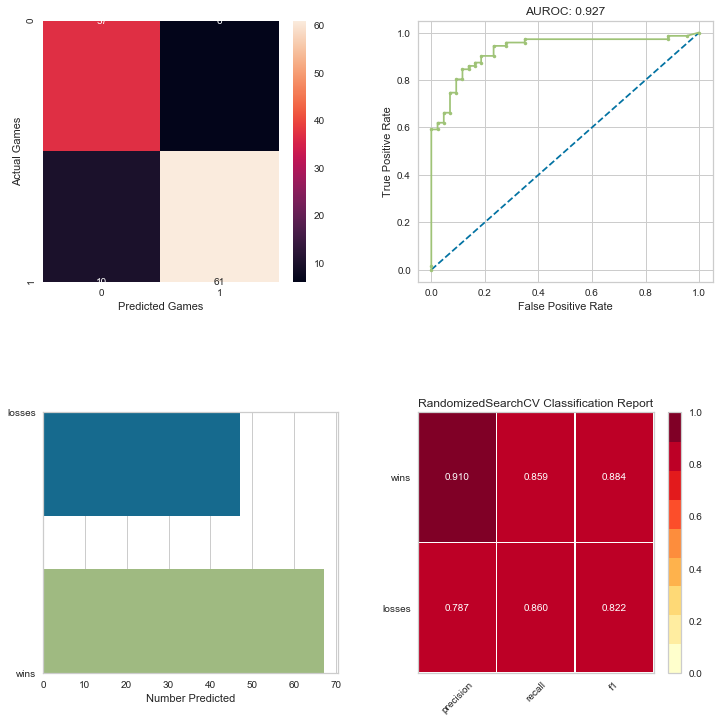

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Best Parameters: {'clf__max_features': 'sqrt'}

Training Accuracy: 1.0
Test Accuracy: 0.86



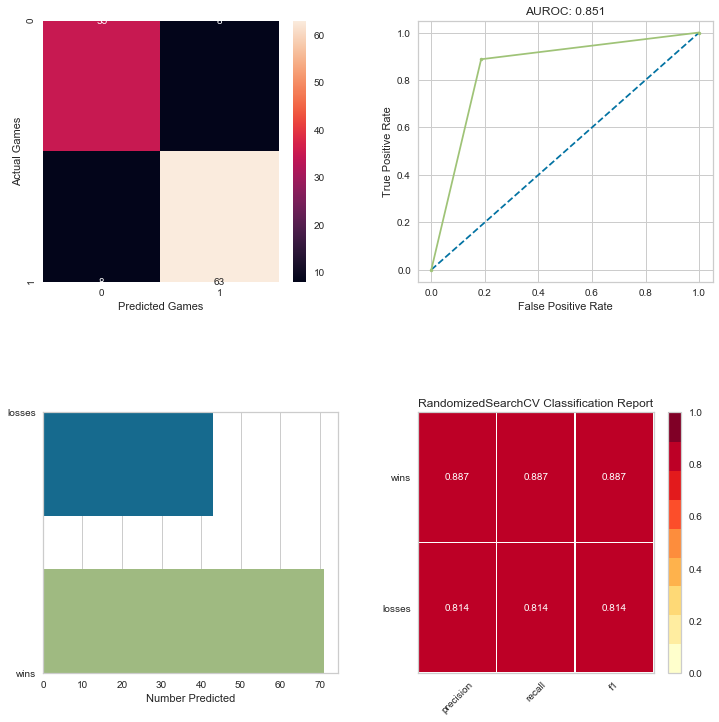

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Best Parameters: {'clf__n_estimators': 177}

Training Accuracy: 1.0
Test Accuracy: 0.93



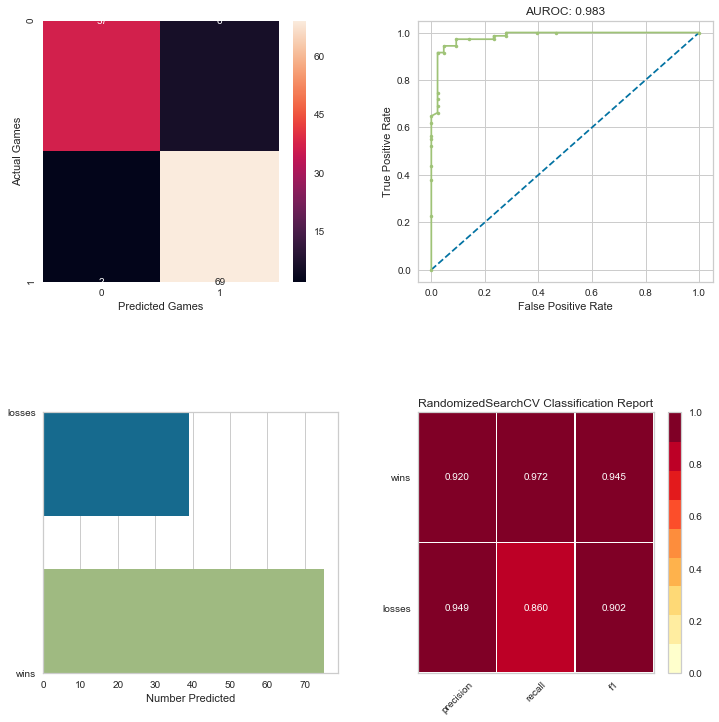

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Best Parameters: {'clf__n_estimators': 200, 'clf__learning_rate': 0.8333333333333333}

Training Accuracy: 1.0
Test Accuracy: 0.89



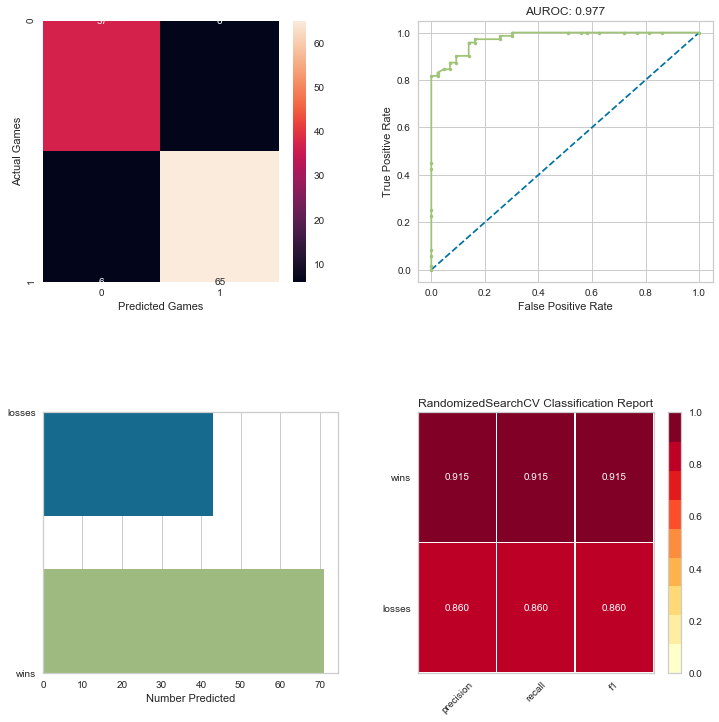

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Best Parameters: {'clf__n_estimators': 144, 'clf__learning_rate': 0.02}

Training Accuracy: 0.98
Test Accuracy: 0.93



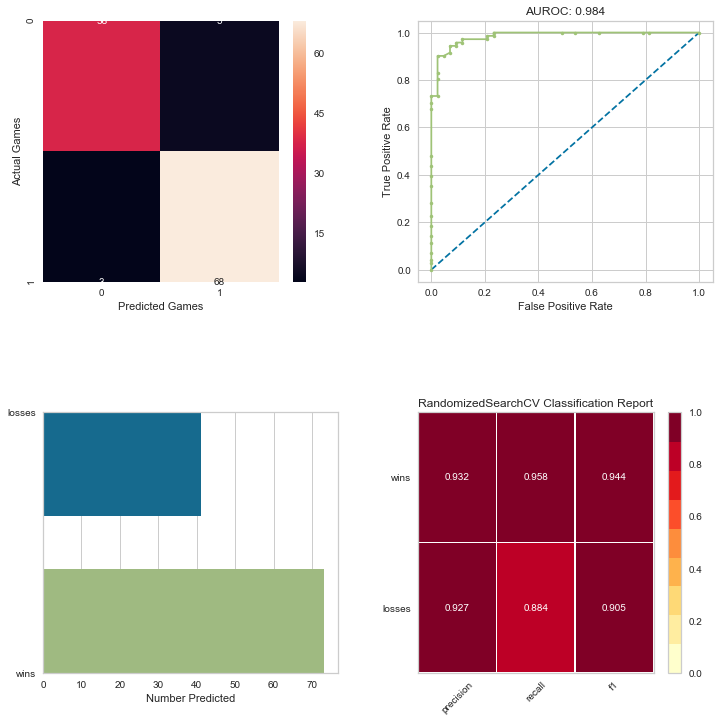

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Best Parameters: {'clf__max_depth': 4, 'clf__booster': 'gbtree'}

Training Accuracy: 1.0
Test Accuracy: 0.92



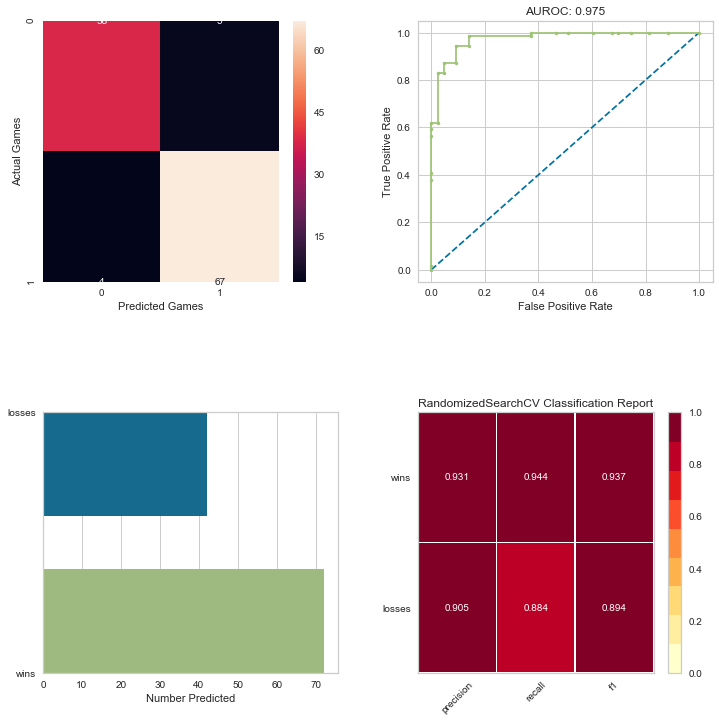

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best Parameters: {'clf__penalty': 'l2', 'clf__C': 0.1}

Training Accuracy: 0.93
Test Accuracy: 0.92



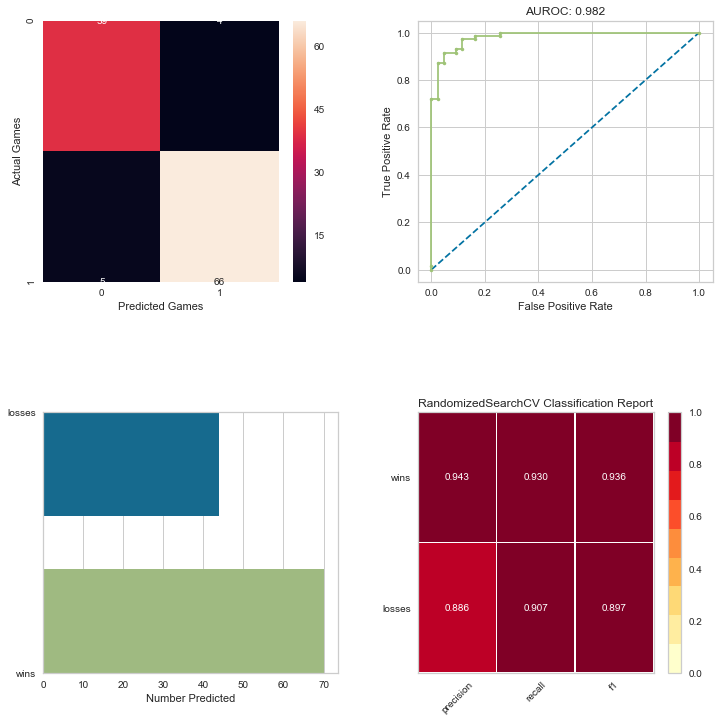

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Best Parameters: {'clf__hidden_layer_sizes': (5, 13, 13)}

Training Accuracy: 0.95
Test Accuracy: 0.92



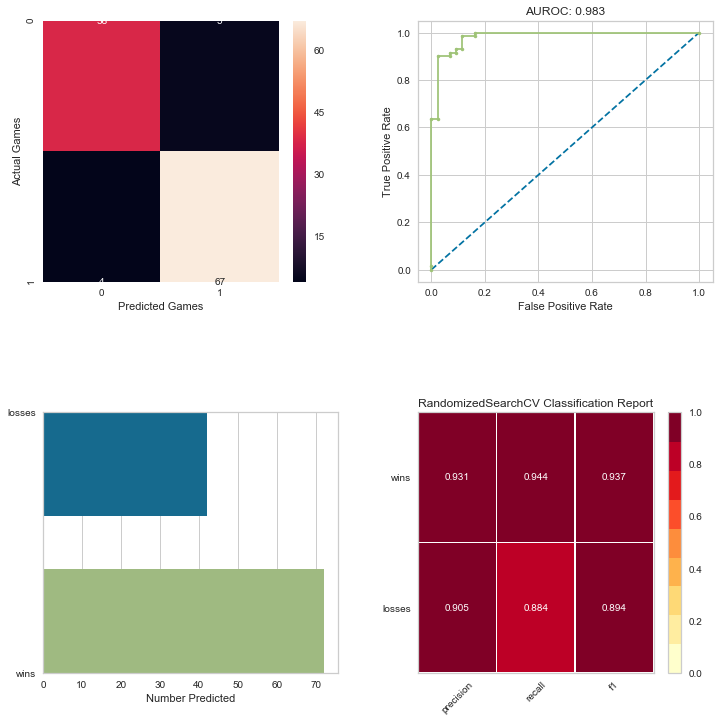

Model parameter search and testing took  32.61 seconds.


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import time

timer_start = time.time()
classifiers = [
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(),
    LogisticRegression(),
    MLPClassifier()
    ]

hidden_layers=np.random.randint(low=5, high=20, size=(10, 3)) # from 5-20 nodes per 3 layers, 10 iterations
hidden_layers=tuple(map(tuple, np.random.randint(low=5, high=20, size=(10, 3)))) # For MLPClassifier
params=[
    { # SVC
        'clf__kernel': ['rbf', 'linear', 'sigmoid'],
        'clf__C': np.logspace(start=-10, stop=10, num=21) # default 1.0
    },
    { # DecisionTreeClassifier
        'clf__max_features': ['sqrt', 'log2']
    },
    { # RandomForestClassifier
        'clf__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32) # default 100
    },
    { # AdaBoostClassifier
        'clf__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'clf__learning_rate': np.linspace(0.5, 1.5, 10, endpoint=True) # default 1.0
    },
    { # GradientBoostingClassifier
        'clf__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'clf__learning_rate': np.linspace(0.02, 0.18, 9, endpoint=True) # default 0.1
    },
    { # XGBClassifier
#     'clf__learning_rate': np.logspace(start=0.01, stop=0.2, num=10, endpoint = True), # see last example in np.logspace documentation
    'clf__max_depth': [2,3,4,5],
    'clf__booster': ['gbtree', 'gblinear', 'dart']
    },
    { # LogisticRegression
    'clf__C': np.logspace(start=-10, stop=10, num=21),
    'clf__penalty': ['none', 'l2']
    },
    { # Neural network multi-layered perceptron, MLPClassifier
      'clf__hidden_layer_sizes': tuple(map(tuple, np.random.randint(low=5, high=20, size=(10, 3)))) 
    }
]

train_acc=[]
test_acc=[]
auc=[]
loggloss=[]
for i, classifier in enumerate(classifiers):
    print(classifier)
    current_clf, train, test, aucc, logloss = clfy_report(classifier, X_train, X_test, y_train, y_test, param_grid=params[i], cv=5)
    train_acc.append(train)
    test_acc.append(test)
    auc.append(aucc)
    loggloss.append(logloss)
end_timer = time.time()
print("Model parameter search and testing took ", round((end_timer - timer_start), 2), "seconds.")

In [4]:
    print(train_acc)
    print(test_acc)
    print(auc)
    print(loggloss)

[0.9868131868131869, 1.0, 1.0, 1.0, 0.9956043956043956, 0.9692307692307692, 0.9406593406593406, 0.9428571428571428]
[0.9122807017543859, 0.8508771929824561, 0.9122807017543859, 0.9035087719298246, 0.9385964912280702, 0.9122807017543859, 0.9385964912280702, 0.9298245614035088]
[0.9623321323288568, 0.8435964624959056, 0.982640026203734, 0.9746151326564035, 0.9801834261382247, 0.9855879462823453, 0.9816573861775303, 0.9832951195545365]
[0.22736005901256454, 5.150519286960365, 0.16494029652136433, 0.6111483797298292, 0.1678824920751396, 0.15641731224604882, 0.18044664919730655, 0.16074500773117884]
